# Investigate dReal->CheckSat 

* For a function f 
* Generate out random samples
* Learn a NN g from samples
* Test dReal->CheckSat on |f-g| > d


In [53]:
import os, re, copy, time

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".1"
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"

import scipy
import numpy as np
from jax import numpy as jnp

import torch.nn as nn
import torch

from tqdm import tqdm
import matplotlib.pyplot as plt

from src.test_functions import *

import dreal

## Helper functions

In [54]:
def sample(function, bounds, n, local_minima=False):
    assert isinstance(bounds, np.ndarray)
    assert bounds.shape[1] == 2
    xs = (
        np.random.rand(n, bounds.shape[0]) * (bounds[:, 1] - bounds[:, 0])
        + bounds[:, 0]
    )
    ys = np.array([function(x).item() for x in xs])

    if local_minima:
        xs_local_opt = []
        ys_local_opt = []
        for x0 in xs:
            opt_res = scipy.optimize.minimize(func, x0, method="Nelder-Mead")
            if opt_res.success:
                xs_local_opt.append(opt_res.x)
                ys_local_opt.append(opt_res.fun)
        xs_local_opt, ys_local_opt = np.array(xs_local_opt), np.array(ys_local_opt)
        return xs, ys, xs_local_opt, ys_local_opt

    return xs, ys

## Function definitions and expressions

In [55]:
dims = 20
fn = Ackley(dims=dims)
var_exp, fn_exp = fn.expression()

# Clean up the expression to match dReal syntax
expression = fn_exp
expression = expression.replace(" ", "")
expression = expression.replace("^", "**")
expression = expression.replace("exp", "dreal.exp")
expression = expression.replace("sin", "dreal.sin")
expression = expression.replace("cos", "dreal.cos")
expression = expression.replace("sqrt", "dreal.sqrt")

to_remove_preceding_sign = True
while to_remove_preceding_sign:
    expression_init = copy.deepcopy(expression)
    # Remove leading + only; leading - is fine
    expression = re.sub(r"\(\s*\+", "(", expression)
    to_remove_preceding_sign = expression_init != expression

fn_exp = expression
print(fn_exp)

(-(20)*dreal.exp(-(0.2)*dreal.sqrt(((x[0]**2)+(x[1]**2)+(x[2]**2)+(x[3]**2)+(x[4]**2)+(x[5]**2)+(x[6]**2)+(x[7]**2)+(x[8]**2)+(x[9]**2)+(x[10]**2)+(x[11]**2)+(x[12]**2)+(x[13]**2)+(x[14]**2)+(x[15]**2)+(x[16]**2)+(x[17]**2)+(x[18]**2)+(x[19]**2))/20)))+(-dreal.exp((dreal.cos((6.283185307179586)*x[0])+dreal.cos((6.283185307179586)*x[1])+dreal.cos((6.283185307179586)*x[2])+dreal.cos((6.283185307179586)*x[3])+dreal.cos((6.283185307179586)*x[4])+dreal.cos((6.283185307179586)*x[5])+dreal.cos((6.283185307179586)*x[6])+dreal.cos((6.283185307179586)*x[7])+dreal.cos((6.283185307179586)*x[8])+dreal.cos((6.283185307179586)*x[9])+dreal.cos((6.283185307179586)*x[10])+dreal.cos((6.283185307179586)*x[11])+dreal.cos((6.283185307179586)*x[12])+dreal.cos((6.283185307179586)*x[13])+dreal.cos((6.283185307179586)*x[14])+dreal.cos((6.283185307179586)*x[15])+dreal.cos((6.283185307179586)*x[16])+dreal.cos((6.283185307179586)*x[17])+dreal.cos((6.283185307179586)*x[18])+dreal.cos((6.283185307179586)*x[19]))/20)

In [56]:
# Variables
x = [dreal.Variable(f"x[{i}]") for i in range(dims)]
f_x = dreal.Variable("f_x")

# Formula
constraint_fn = dreal.And(eval(fn_exp + " == f_x"))

## Make NN to learn the function

In [86]:
# Setup NN training
nsamples = int(dims * 1000)
hidden_dim = 16

# Training epochs
num_epochs = 10000

In [87]:
# Generate samples from the function
bounds = fn.get_default_domain()
sampled_xs, sampled_ys = sample(fn, bounds, dims, local_minima=False)


# Training prepare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xs_train = sampled_xs
ys_train = np.expand_dims(sampled_ys, axis=1)


model = nn.Sequential(nn.Linear(dims, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))

criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [88]:
model.to(device)

loss_record = []
for epoch in tqdm(range(num_epochs)):
    model.train()

    x_train_tensor = torch.FloatTensor(xs_train).to(device)
    y_train_tensor = torch.FloatTensor(ys_train).to(device)
    y_pred = model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    loss_record.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

100%|██████████| 10000/10000 [00:06<00:00, 1640.71it/s]


0.020644310861825943


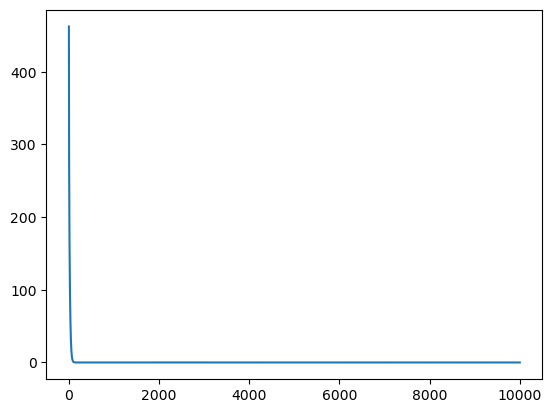

In [94]:
plt.plot(loss_record)
print(loss_record[-1])

## Convert the neural network to dReal

In [90]:
curr_vars = x
formulas_by_layer = []
vars_by_layer = [x]

for layer_idx, layer in enumerate(model):
    prev_vars = curr_vars
    if isinstance(layer, nn.Linear):
        W = layer.weight.detach().cpu().numpy()
        b = np.expand_dims(layer.bias.detach().cpu().numpy(), axis=1)
        X = np.expand_dims(prev_vars, axis=1)

        curr_vars = [
            dreal.Variable("xt[{}][{}]".format(layer_idx + 1, i))
            for i in range(W.shape[0])
        ]
        vars_by_layer.append(curr_vars)
        expressions = (W @ X + b)[:, 0]

        formulas = [
            (curr_var == expr) for curr_var, expr in zip(curr_vars, expressions)
        ]
        formulas_by_layer.append(formulas)

    elif isinstance(layer, nn.ReLU):
        layer_width = len(prev_vars)
        curr_vars = [
            dreal.Variable("xt[{}][{}]".format(layer_idx + 1, i))
            for i in range(layer_width)
        ]
        vars_by_layer.append(curr_vars)

        expressions = [dreal.Max(0, prev_var) for prev_var in prev_vars]

        formulas = [
            (curr_var == expr) for curr_var, expr in zip(curr_vars, expressions)
        ]
        formulas_by_layer.append(formulas)

all_formulas_nn = [formula for formulas in formulas_by_layer for formula in formulas]

# g_x: output value
g_x = vars_by_layer[-1][0]

# Check
all_formulas_nn

[<Formula "(xt[1][0] == (0.21754032373428345 - 0.39169600605964661 * x[0] + 0.33425503969192505 * x[1] - 0.11998503655195236 * x[2] - 0.34773936867713928 * x[3] - 0.1977207213640213 * x[4] - 0.3386211097240448 * x[5] + 0.012131412513554096 * x[6] - 0.2641797661781311 * x[7] - 0.11186695843935013 * x[8] - 0.048087108880281448 * x[9] + 0.15209347009658813 * x[10] + 0.30962556600570679 * x[11] - 0.04224078357219696 * x[12] + 0.05303502082824707 * x[13] + 0.017563106492161751 * x[14] - 0.010543989948928356 * x[15] - 0.10139160603284836 * x[16] - 0.2712339460849762 * x[17] + 0.19658169150352478 * x[18] - 0.039159554988145828 * x[19]))">,
 <Formula "(xt[1][1] == (-0.36122387647628784 + 0.035264808684587479 * x[0] + 0.092876128852367401 * x[1] - 0.070781029760837555 * x[2] + 0.11156214028596878 * x[3] + 0.043487578630447388 * x[4] - 0.060623504221439362 * x[5] - 0.14289397001266479 * x[6] - 0.04702402651309967 * x[7] - 0.038740716874599457 * x[8] - 0.062086034566164017 * x[9] - 0.042780861258

## Check Satifisability

In [98]:
# Three arguments
d = 100.0  # |f(x) - g(x)| >= d
precision = 1.0  # |f(x) - g(x)| >= d - precision
box = fn.get_default_domain()  # Set the box

box = [[-5, 5]] * dims

print(box[0])

[-5, 5]


In [99]:
# Make box as a dReal constraint
interval_symbol = []
for i in range(dims):
    lb, ub = box[i]
    interval_symbol.append(f"x[{i}] >= {lb}")
    interval_symbol.append(f"x[{i}] <= {ub}")

constraint_box = eval(interval_symbol[0])
for i in range(1, len(interval_symbol)):
    constraint_box = dreal.And(constraint_box, eval(interval_symbol[i]))

print(constraint_box)

# Set |f(x) - g(x)| >= d
constraint_error = dreal.Or(g_x <= f_x - d, g_x >= f_x + d)

# Set all constraints
constraint_all = dreal.And(
    constraint_box, constraint_fn, *all_formulas_nn, constraint_error
)
print(constraint_all)

((x[0] >= -5) and (x[1] >= -5) and (x[2] >= -5) and (x[3] >= -5) and (x[4] >= -5) and (x[5] >= -5) and (x[6] >= -5) and (x[7] >= -5) and (x[8] >= -5) and (x[9] >= -5) and (x[10] >= -5) and (x[11] >= -5) and (x[12] >= -5) and (x[13] >= -5) and (x[14] >= -5) and (x[15] >= -5) and (x[16] >= -5) and (x[17] >= -5) and (x[18] >= -5) and (x[19] >= -5) and (x[0] <= 5) and (x[1] <= 5) and (x[2] <= 5) and (x[3] <= 5) and (x[4] <= 5) and (x[5] <= 5) and (x[6] <= 5) and (x[7] <= 5) and (x[8] <= 5) and (x[9] <= 5) and (x[10] <= 5) and (x[11] <= 5) and (x[12] <= 5) and (x[13] <= 5) and (x[14] <= 5) and (x[15] <= 5) and (x[16] <= 5) and (x[17] <= 5) and (x[18] <= 5) and (x[19] <= 5))
((xt[1][0] == (0.21754032373428345 - 0.39169600605964661 * x[0] + 0.33425503969192505 * x[1] - 0.11998503655195236 * x[2] - 0.34773936867713928 * x[3] - 0.1977207213640213 * x[4] - 0.3386211097240448 * x[5] + 0.012131412513554096 * x[6] - 0.2641797661781311 * x[7] - 0.11186695843935013 * x[8] - 0.048087108880281448 * x[9

In [100]:
# Run and analyze the result
start = time.time()
result = dreal.CheckSatisfiability(constraint_all, precision)
end = time.time()

try:
    for i in range(len(x)):
        print(x[i], box[i], result[x[i]], f"{end - start:.2f}", sep=" ; ")
        break
except:
    print(result)

None


# dreal examples

In [1]:
import dreal

In [60]:
# Check defining the variables.
dims = 2
x = [dreal.Variable(f"x[{i}]") for i in range(dims)]

In [61]:
# Check defining the constraints.
constraint_box = dreal.And(x[0] >= 0, x[0] <= 1, x[1] >= 0, x[1] <= 1)
constraint_box

<Formula "((x[0] >= 0) and (x[1] >= 0) and (x[0] <= 1) and (x[1] <= 1))">

In [63]:
# Check defining the constraints with different syntax.
c = dreal.Variable("x")
d = dreal.Variable("y")

constraints = dreal.And(c >= 0, c <= 1, d >= 0, d <= 1)
constraints

<Formula "((x >= 0) and (y >= 0) and (x <= 1) and (y <= 1))">

In [65]:
# Check defining the formula.
formulus1 = dreal.And(x[0] + x[1] >= 1, x[0] - x[1] ** 2 <= 0.3)
print(formulus1)

(((x[0] + x[1]) >= 1) and ((x[0] - pow(x[1], 2)) <= 0.29999999999999999))


In [64]:
# Check defining the formula with eval and expression
expression = "x[0] + x[1] >= 1"
formulus2 = dreal.And(eval(expression), x[0] >= 0, x[0] <= 1, x[1] >= 0, x[1] <= 1)
print(formulus2)

((x[0] >= 0) and (x[1] >= 0) and ((x[0] + x[1]) >= 1) and (x[0] <= 1) and (x[1] <= 1))


In [68]:
# Check assiging a box
box = dreal.Box(x)
box[x[0]] = dreal.Interval(0, 1)
box[x[1]] = dreal.Interval(0, 1)

In [70]:
# Check config
config = dreal.Config()
config.precision = 0.001

In [71]:
result = dreal.CheckSatisfiability(formulus2, config)
print(result)

x[0] : [0.49951171875, 0.5]
x[1] : [0.5, 0.50048828125]


# Interpret function symbolic expression to dreal

In [15]:
import re, copy
from src.test_functions import *

from dreal import sin, cos, exp, log, sqrt, Variable, And, CheckSatisfiability

In [71]:
dims = 2
fn = Ackley(dims)
var_exp, fn_exp = fn.expression()

In [72]:
x = [Variable(f"x[{i}]") for i in range(dims)]

In [75]:
fn_val = Variable("fn_val")

expression = f"{fn_exp} == fn_val"

# Clean up the expression to match dReal syntax
expression = expression.replace(" ", "")
expression = expression.replace("^", "**")
# expression = expression.replace("exp", "dreal.exp")
# expression = expression.replace("sin", "dreal.sin")
# expression = expression.replace("cos", "dreal.cos")
# expression = expression.replace("sqrt", "dreal.sqrt")

to_remove_preceding_sign = True
while to_remove_preceding_sign:
    expression_init = copy.deepcopy(expression)

    expression = re.sub(r"\(\s*\+", "(", expression)
    # expression = re.sub(r"\(\s*\-", "(", expression)

    to_remove_preceding_sign = expression_init != expression

print(expression)

(-(20)*exp(-(0.2)*sqrt(((x[0]**2)+(x[1]**2))/2)))+(-exp((cos((6.283185307179586)*x[0])+cos((6.283185307179586)*x[1]))/2))+((20)+exp(1.0))==fn_val


In [76]:
constraint_expression = And(eval(expression), fn_val == 0)
print(constraint_expression)

((fn_val == 0) and ((20 + exp(1) - 20 * exp((-0.20000000000000001 * sqrt(((pow(x[0], 2) + pow(x[1], 2)) / 2)))) - exp(((cos((6.2831853071795863 * x[0])) + cos((6.2831853071795863 * x[1]))) / 2))) == fn_val))


In [77]:
intervals = fn.get_default_domain()

interval_symbol = []
for i in range(dims):
    lb, ub = intervals[i]
    interval_symbol.append(f"x[{i}] >= {lb}")
    interval_symbol.append(f"x[{i}] <= {ub}")

constraint_box = eval(interval_symbol[0])
for i in range(1, len(interval_symbol)):
    constraint_box = And(constraint_box, eval(interval_symbol[i]))

print(constraint_box)

((x[0] >= -32.768) and (x[1] >= -32.768) and (x[0] <= 32.768000000000001) and (x[1] <= 32.768000000000001))


In [78]:
constraint_all = And(constraint_box, constraint_expression)
print(constraint_all)

((fn_val == 0) and ((20 + exp(1) - 20 * exp((-0.20000000000000001 * sqrt(((pow(x[0], 2) + pow(x[1], 2)) / 2)))) - exp(((cos((6.2831853071795863 * x[0])) + cos((6.2831853071795863 * x[1]))) / 2))) == fn_val) and (x[0] >= -32.768) and (x[1] >= -32.768) and (x[0] <= 32.768000000000001) and (x[1] <= 32.768000000000001))


In [79]:
precision = 0.001
result = CheckSatisfiability(constraint_all, precision)
print(result)

x[0] : [-3.1401849173675553e-15, 3.1401849173675554e-15]
x[1] : [-3.1401849173675553e-15, 3.1401849173675554e-15]
fn_val : [0, 0]


In [ ]:
# class dRealExpression:
#     def __init__(self) -> None:
#         self.variables = []
#         self.constraints = []

#     def add_variable(self, name: str):
#         return

#     def intervals_to_constraints(self, intervals: list):
#         """
#         Convert a list of intervals to dReal constraints.

#         Args:
#             intervals (list): A list of intervals [[lb, ub], [lb, ub], ...]
#         Returns:
#             constraints (dreal.Formula): A dReal formula.
#         """

#         assert isinstance(
#             intervals, list
#         ), "Input intervals must be a list [(lb, ub), (lb, ub), ...]"

#         x = self.variables

#         interval_symbol = []
#         for i in range(dims):
#             lb, ub = intervals[i]
#             interval_symbol.append(f"x[{i}] >= {lb}")
#             interval_symbol.append(f"x[{i}] <= {ub}")

#         constraints = eval(interval_symbol[0])
#         for i in range(1, len(interval_symbol)):
#             constraints = dreal.And(constraints, eval(interval_symbol[i]))

#         return constraints